In [1]:
import os
import json
import hoomd
import codecs

import numpy as np

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render
import polychrom_hoomd.extrude as extrude

from discrete_time_extrusion.Translocator import Translocator

from discrete_time_extrusion.extruders.BaseExtruder import BaseExtruder
from discrete_time_extrusion.boundaries.StaticBoundary import StaticBoundary

from polykit.generators.initial_conformations import grow_cubic

In [2]:
# Initialise HOOMD on the CPU or GPU, based on availability
hoomd_device = build.get_hoomd_device()

HOOMD is running on the following GPU(s):
[0] NVIDIA A100 80GB PCIe 108 SM_8.0 @ 1.41 GHz, 81155 MiB DRAM


In [3]:
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 22356


In [4]:
# Initialize empty simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [5]:
# Simulate two chromosomes comprised of 5000 (resp. 10000) monomers each, with number density 0.2
density = 0.2
chromosome_sizes = [500]

In [6]:
# Confine chromosomes within a sphere of appropriate radius
number_of_monomers = sum(chromosome_sizes)
confinement_radius = (3*number_of_monomers / (4*np.pi*density))**(1/3.)

In [7]:
# Set simulation box large enough to accomodate the chromosomes
snapshot = build.get_simulation_box(box_length=2*confinement_radius, pad=1.)

In [8]:
# Build random, dense initial conformations
inscribed_cube_length = confinement_radius*2/3**.5
monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(inscribed_cube_length))

In [9]:
# Parse force parameters
with open("../data/force_dict_full.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

In [10]:
# Parse particle/bond types
bond_types = force_dict['Bonded forces'].keys()
angle_types = force_dict['Angular forces'].keys()
monomer_types = force_dict['Non-bonded forces']['Attraction']['Matrix'].keys()

In [11]:
# Populate snapshot with the generated chains
build.set_chromosomes(snapshot, monomer_positions, chromosome_sizes,
                      bond_type_list=list(bond_types), monomer_type_list=list(monomer_types),
                      angle_type_list=list(angle_types))

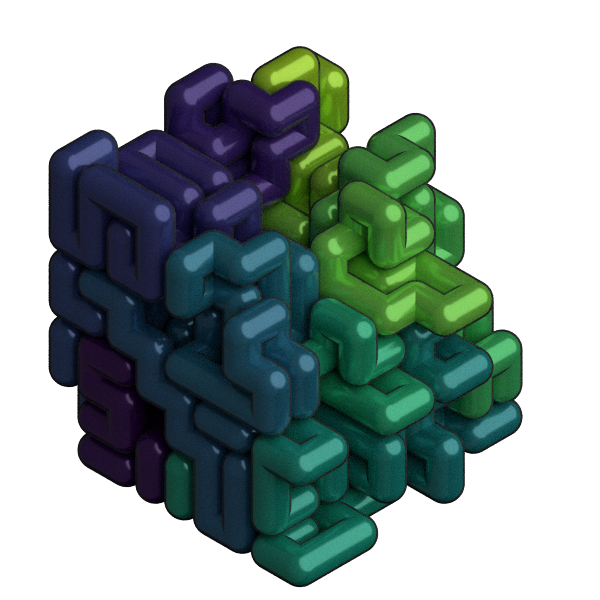

In [12]:
# Render individual chromosomes using the Fresnel backend
render.fresnel(snapshot).static()

In [13]:
# Setup HooMD simulation object
system.create_state_from_snapshot(snapshot)

In [14]:
# Setup neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.2)

In [15]:
# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [16]:
# Set bonded/angular potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
angular_forces = forces.get_angular_forces(**force_dict)

In [17]:
# Define full force_field
force_field = repulsion_forces + bonded_forces + angular_forces 

In [18]:
# HooMD to openMM time conversion factor
t_conv = (1.67377*10**-27/(1.380649*10**-23*300))**0.5

In [19]:
# Initialize integrators and Langevin thermostat
langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
integrator = hoomd.md.Integrator(dt=70*t_conv, methods=[langevin], forces=force_field)

In [20]:
# Setup simulation engine
system.operations.integrator = integrator

In [21]:
# Run
system.run(1e5)

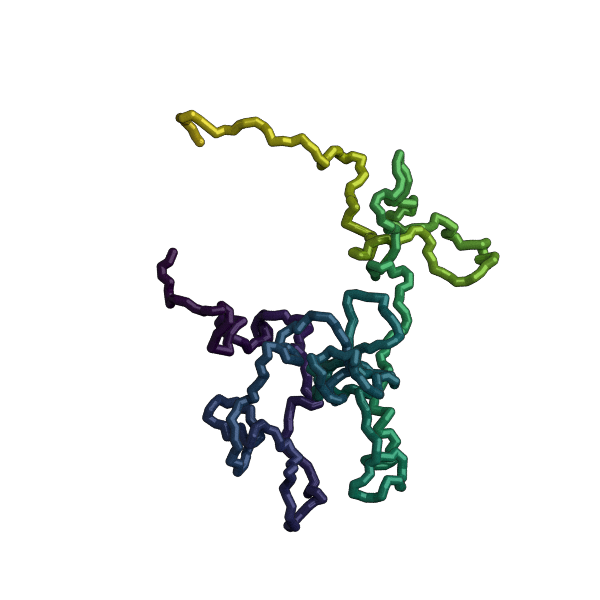

In [22]:
# Visualize equilibrated domains in 3D
snapshot_equilibrated = system.state.get_snapshot()
render.fresnel(snapshot_equilibrated).static()

In [23]:
# Parse extrusion parameters
with open("../data/extrusion_dict.json", 'r') as dict_file:
    extrusion_dict = json.load(dict_file)

extrusion_dict['monomers_per_replica'] = number_of_monomers

In [24]:
# Create translocator object
translocator = Translocator(BaseExtruder,
                            StaticBoundary,
                            snapshot.particles.types,
                            snapshot.particles.typeid,
                            [],
                            [],
                            device='GPU',
                            **extrusion_dict)

In [25]:
steps_per_loop = extrusion_dict['3D_to_1D_steps']/extrusion_dict['velocity_multiplier']

for extrusion_step in range(translocator.params['dummy_steps']):
    translocator.run(1)
    system.run(steps_per_loop)
    
    extrude.update_topology(system, translocator.extrusion_engine.positions)

/home1/tortora/tmp/tmp/discrete-time-extrusion/discrete_time_extrusion/extruders/EngineFactory.py:95: UserWarning: Running lattice extrusion on the GPU
  warnings.warn("Running lattice extrusion on the GPU")
/home1/tortora/tmp/tmp/polychrom-hoomd/polychrom_hoomd/extrude.py:53: UserWarning: Unable to dynamically resize bond arrays on the GPU - reverting to non-local topology update
  warnings.warn("%s - reverting to non-local topology update" % e)
/home1/tortora/tmp/tmp/polychrom-hoomd/polychrom_hoomd/extrude.py:49: UserWarning: Using local topology update
  warnings.warn("Using local topology update")


In [26]:
rest_dist = force_dict["Bonded forces"]["LEF"]["Rest length"]
wiggle_dist = force_dict["Bonded forces"]["LEF"]["Wiggle distance"]

step_dist = 2 * wiggle_dist

In [27]:
def run_boltzmann_extrusion(system, translocator, step_dist, rest_dist, steps_per_loop):
    rejected_tally = 0.
    
    for extrusion_step in range(translocator.params['steps']):
        current_positions = translocator.extrusion_engine.positions.get()
    
        translocator.run(1)
        system.run(steps_per_loop)
    
        trial_positions = translocator.extrusion_engine.positions.get()
        accepted_positions = extrude.boltzmann_criterion(system, current_positions, trial_positions, 
                                                         step_dist=step_dist, rest_dist=rest_dist)
    
        is_bound = np.all(current_positions>0, axis=1) * np.all(trial_positions>0, axis=1)
        num_bound = np.count_nonzero(is_bound)
        
        rejected_moves = np.count_nonzero(np.all(trial_positions[is_bound] != accepted_positions.get()[is_bound], axis=1))
        rejected_tally += rejected_moves / num_bound if num_bound>0 else 0.
        
        extrude.update_topology(system, accepted_positions)
        translocator.extrusion_engine.positions = accepted_positions

    return rejected_tally/translocator.params['steps']

In [28]:
rejected_count = run_boltzmann_extrusion(system, translocator, step_dist, rest_dist, steps_per_loop)

print('Rejected %.1f%% of trial extrusion moves' % (rejected_count * 100))

Rejected 52.8% of trial extrusion moves


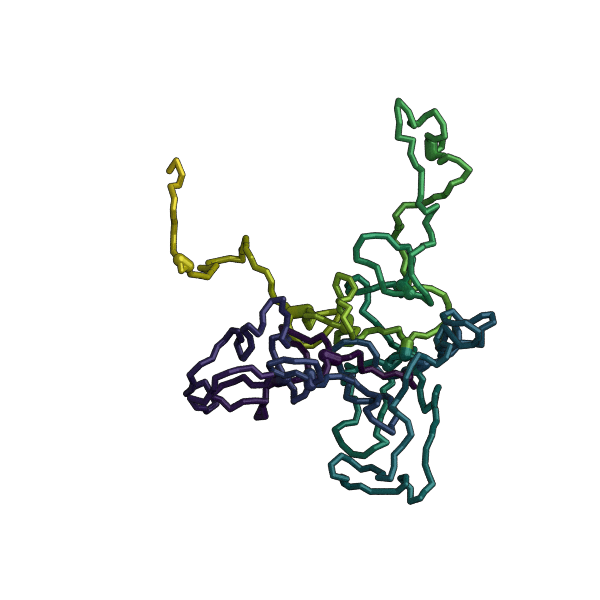

In [29]:
# Visualize new extrusion bonds 
snapshot_looped = system.state.get_snapshot()
render.fresnel(snapshot_looped, rescale_backbone_bonds=0.5).static()

In [30]:
# Setup stretching force along the x axis with magnitude ~1 pN
stretching_force = 10.

In [31]:
external_force_dict = {}

left_stretching_force =  {'x': -stretching_force, 'y': 0, 'z': 0}
right_stretching_force = {'x': +stretching_force, 'y': 0, 'z': 0}

external_force_dict['Vector'] = {'Pull left end': left_stretching_force,
                                 'Pull right end': right_stretching_force}

force_dict['External forces']['Constant'] = external_force_dict

In [32]:
leftmost_monomer = hoomd.filter.Tags(0)
rightmost_monomer = hoomd.filter.Tags(number_of_monomers-1)

In [33]:
stretching_forces = forces.get_constant_forces([leftmost_monomer, rightmost_monomer], **force_dict)
integrator.forces = force_field + stretching_forces

In [34]:
# Run
system.run(1e6)

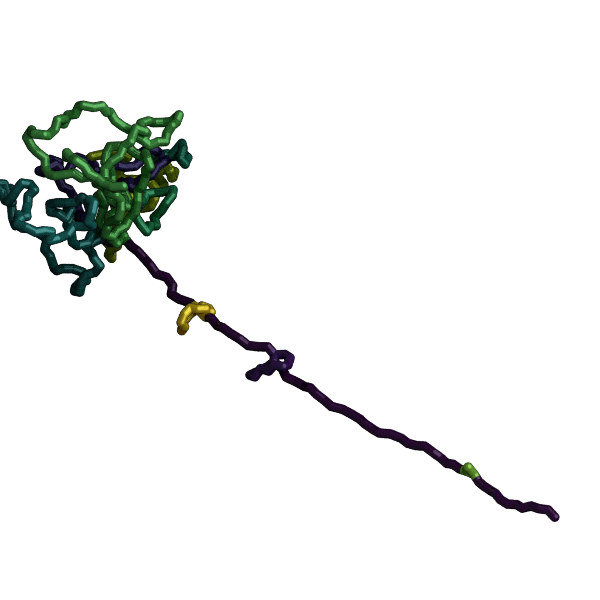

In [35]:
# Visualize stretched conformation in 3D
snapshot_stretched = system.state.get_snapshot()
render.fresnel(snapshot_stretched, show='loops').static()

In [36]:
rejected_count_stretch = run_boltzmann_extrusion(system, translocator, step_dist, rest_dist, steps_per_loop)

print('Rejected %.1f%% of trial extrusion moves with applied force' % (rejected_count_stretch * 100))

Rejected 82.9% of trial extrusion moves with applied force


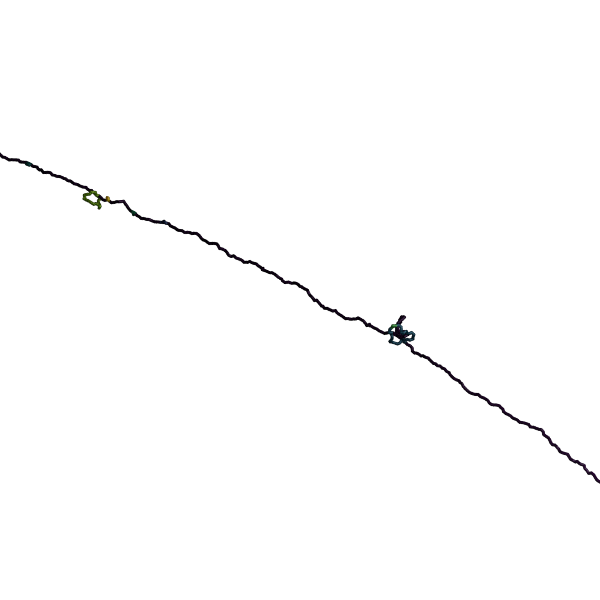

In [37]:
# Visualize stretched conformation in 3D
snapshot_final = system.state.get_snapshot()
render.fresnel(snapshot_final, show='loops').static()